In [1]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB , quicksum
import matplotlib.pyplot as plt

# Step 1: Load data and compute returns
data_2023 = pd.read_csv(r"C:/Users/91779/Downloads/2023data (1).csv")
data_2024 = pd.read_csv(r"C:/Users/91779/Downloads/2024data (1).csv")

#data_2023 = pd.read_csv(r"C:/Users/91779/Downloads/2023data (1) - Copy.csv")

# Step 2 for m = 5

In [2]:
# FIlling Nan with back fill and forward fill
data_2023 = data_2023.interpolate(method='linear', axis=0).fillna(method='ffill').fillna(method='bfill')
data_2024 = data_2024.interpolate(method='linear', axis=0).fillna(method='ffill').fillna(method='bfill')

# Compute daily returns
returns_2023 = data_2023.iloc[:, 1:].pct_change().fillna(0)
returns_2024 = data_2024.iloc[:, 1:].pct_change().fillna(0)

index_returns_2023 = returns_2023.iloc[:, 0]
stock_returns_2023 = returns_2023.iloc[:, 1:]

index_returns_2024 = returns_2024.iloc[:, 0]
stock_returns_2024 = returns_2024.iloc[:, 1:]

# Compute correlation matrix (ρ)
rho = stock_returns_2023.corr().values


# Step 2: Solve the IP for selecting 5 stocks
def select_stocks(m, rho):
    n = rho.shape[0]
    model = Model()
    
    # Decision variables
    y = model.addVars(n, vtype=GRB.BINARY, name="y")
    x = model.addVars(n, n, vtype=GRB.BINARY, name="x")
    
    # Objective: Maximize similarity
    model.setObjective(quicksum(rho[i, j] * x[i, j] for i in range(n) for j in range(n)), GRB.MAXIMIZE)
    
    # Constraints
    model.addConstr(quicksum(y[j] for j in range(n)) == m)  # Select exactly m stocks
    for i in range(n):
        model.addConstr(quicksum(x[i, j] for j in range(n)) == 1)  # Every stock has a representative
        for j in range(n):
            model.addConstr(x[i, j] <= y[j])  # A stock can only be a representative if selected

    # Optimize model
    model.Params.OutputFlag = 0
    model.optimize()
    
    selected_stocks = [j for j in range(n) if y[j].x > 0.5]

    return selected_stocks

# Step 3: Construct weights to match the index return with robust indexing
def optimize_weights(selected_stocks, stock_returns, index_returns):
    T = len(index_returns)  # Number of time periods
    m = len(selected_stocks)  # Number of selected stocks

    # Create LP model for weight optimization
    model = Model()
    weights = model.addVars(m, lb=0, name="w")  # Non-negative weights
    deviations = model.addVars(T, lb=0, name="dev")  # Deviations for absolute differences

    # Convert index returns and stock returns to NumPy arrays for easier operations
    index_returns_array = index_returns.to_numpy()
    selected_stock_returns = stock_returns.iloc[:, selected_stocks].to_numpy()

    # Objective: Minimize sum of absolute deviations
    model.setObjective(quicksum(deviations[t] for t in range(T)), GRB.MINIMIZE)

    # Constraints for each time period
    for t in range(T):
        portfolio_return_t = quicksum(weights[i] * selected_stock_returns[t, i] for i in range(m))
        model.addConstr(deviations[t] >= index_returns_array[t] - portfolio_return_t)
        model.addConstr(deviations[t] >= portfolio_return_t - index_returns_array[t])

    # Sum of weights should be 1
    model.addConstr(quicksum(weights[i] for i in range(m)) == 1)

    # Optimize the model
    model.Params.OutputFlag = 0
    model.optimize()

    # Extract optimized weights
    optimized_weights = [weights[i].x for i in range(m)]
    return optimized_weights


"""def calculate_tracking_error(weights, selected_stocks, stock_returns_2024, index_returns_2024):
    # Convert selected indices to column names (tickers)
    selected_columns = stock_returns_2024.columns[selected_stocks]

    # Extract the relevant stock returns for the selected columns
    selected_returns = stock_returns_2024[selected_columns]

    # Compute portfolio returns
    portfolio_returns = selected_returns.dot(weights)

    # Calculate tracking error as the sum of absolute differences
    #tracking_error = np.mean(np.abs(index_returns_2024.values - portfolio_returns.values))
    tracking_error = np.sum(np.abs(index_returns_2024.values - portfolio_returns.values))
    return tracking_error"""
# ---------------------
# Step 4: Calculate tracking error for 2024 with proper column extraction
def evaluate_performance(weights, selected_stocks, stock_returns, index_returns):
    # Convert selected indices to column names (tickers)
    selected_columns = stock_returns.columns[selected_stocks]

    # Extract the relevant stock returns for the selected columns
    selected_returns = stock_returns[selected_columns].dropna()

    # Align index returns with the selected stock returns
    aligned_index_returns = index_returns.loc[selected_returns.index]

    # Compute portfolio returns using matrix multiplication
    portfolio_returns = selected_returns.values @ np.array(weights)

    # Calculate cumulative returns for portfolio and index
    cumulative_portfolio_returns = np.cumprod(1 + portfolio_returns) - 1
    cumulative_index_returns = np.cumprod(1 + aligned_index_returns.values) - 1

    # Calculate tracking error as the mean absolute difference
    tracking_error = np.sum(np.abs(portfolio_returns - aligned_index_returns.values))

    return cumulative_portfolio_returns, cumulative_index_returns, tracking_error
# -----------------------------------
# Run the optimization for m=5 with debugging output

selected = select_stocks(5, rho)
print(f"Selected Stocks (Indices): {selected}")
print(f"Selected Stock Names: {stock_returns_2024.columns[selected]}")

weights = optimize_weights(selected, stock_returns_2023, index_returns_2023)
print(f"Weights: {weights}")




# Evaluate in-sample performance on 2023 data
cumulative_portfolio_returns_2023, cumulative_index_returns_2023, tracking_error_2023 = \
    evaluate_performance(weights, selected, stock_returns_2023, index_returns_2023)
print(f"In-Sample Tracking Error (2023): {tracking_error_2023}")

# Evaluate out-of-sample performance on 2024 data
cumulative_portfolio_returns_2024, cumulative_index_returns_2024, tracking_error_2024 = \
    evaluate_performance(weights, selected, stock_returns_2024, index_returns_2024)
print(f"Out-of-Sample Tracking Error (2024): {tracking_error_2024}")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26
Selected Stocks (Indices): [47, 51, 72, 81, 88]
Selected Stock Names: Index(['HON', 'INTU', 'NXPI', 'PEP', 'SNPS'], dtype='object')
Weights: [0.13532789738415657, 0.22717045376089448, 0.17194387052368587, 0.21077735222975874, 0.25478042610150436]
In-Sample Tracking Error (2023): 1.110995364050066
Out-of-Sample Tracking Error (2024): 1.0238370716302163


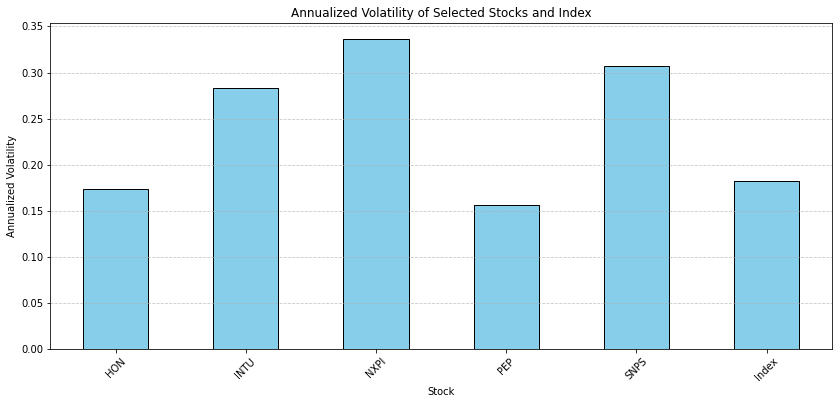

In [3]:
#From this graph we can visualize the Annualized Volatility of Selected Stocks compared to the Index

returns_2023_selected1 = stock_returns_2023.iloc[:, selected]
returns_2024_selected1 = stock_returns_2024.iloc[:, selected]

# Combine both returns with the index for easier plotting
returns_selected_combined = pd.concat([returns_2023_selected1, returns_2024_selected1])
index_returns_combined = pd.concat([index_returns_2023, index_returns_2024], axis=0)
returns_selected_combined['Index'] = index_returns_combined

# Calculate annualized volatility (252 trading days in a year)
annualized_volatility = returns_selected_combined.std() * np.sqrt(252)

# Plot annualized volatility for the selected stocks and index
plt.figure(figsize=(14, 6))
annualized_volatility.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Annualized Volatility of Selected Stocks and Index")
plt.xlabel("Stock")
plt.ylabel("Annualized Volatility")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## step 3 with m = 10, 20, ..., 90, 100

m = 5: Tracking Error 2023 = 1.110995364050066, Tracking Error 2024 = 1.0238370716302163, Selected Stock Names: Index(['HON', 'INTU', 'NXPI', 'PEP', 'SNPS'], dtype='object'), Weights: [0.13532789738415657, 0.22717045376089448, 0.17194387052368587, 0.21077735222975874, 0.25478042610150436]


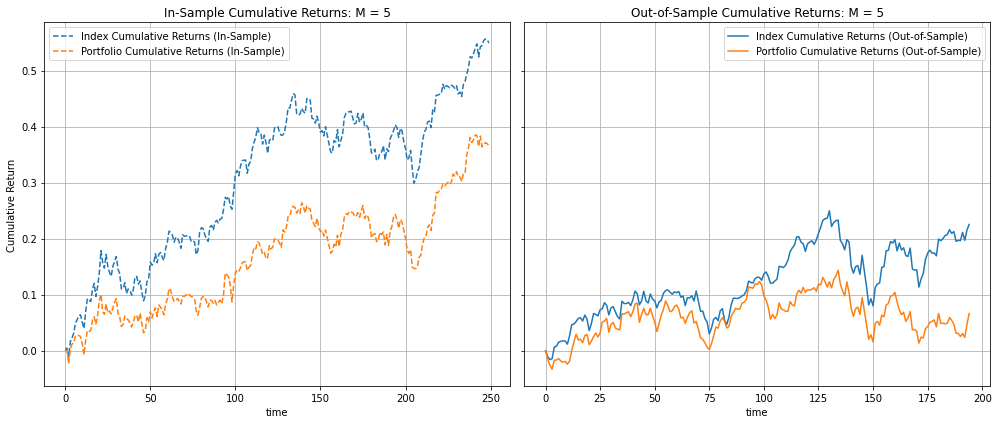

m = 10: Tracking Error 2023 = 0.8861723964353692, Tracking Error 2024 = 0.7616286935427032, Selected Stock Names: Index(['AMZN', 'AEP', 'CRWD', 'FANG', 'GILD', 'HON', 'IDXX', 'NXPI', 'PEP',
       'SNPS'],
      dtype='object'), Weights: [0.2512101113252907, 0.023139790543402993, 0.0396633760170998, 0.04164801946111542, 0.06632887248182401, 0.009846215806206569, 0.060283431168596184, 0.15681078357742742, 0.17823249606458594, 0.17283690355445108]


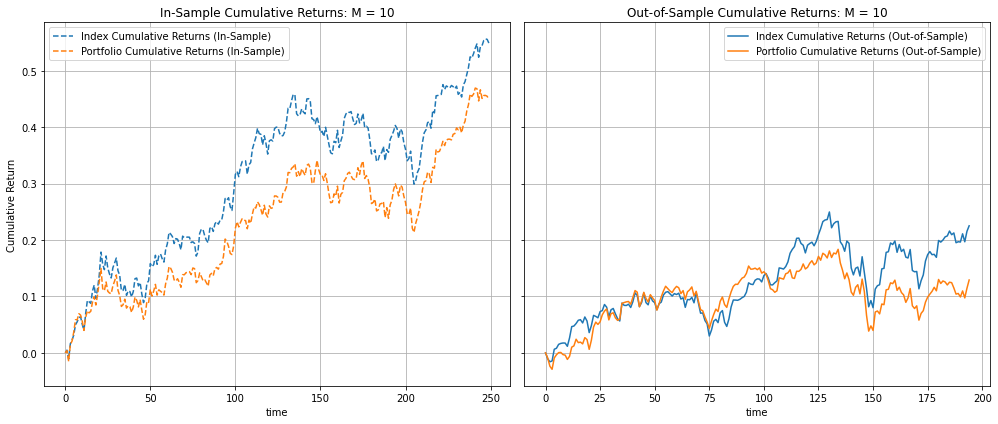

m = 20: Tracking Error 2023 = 0.8155820174639565, Tracking Error 2024 = 0.6256895794242114, Selected Stock Names: Index(['ABNB', 'AMZN', 'AEP', 'AMAT', 'ARM', 'AZN', 'ADP', 'CHTR', 'CRWD',
       'DXCM', 'FANG', 'GILD', 'HON', 'IDXX', 'MRNA', 'NXPI', 'PEP', 'ROST',
       'SNPS', 'TTWO'],
      dtype='object'), Weights: [0.010204365243905607, 0.22340634310348526, 0.026747623306948076, 0.07650598518871964, 0.016503522055985376, 0.013947299103224176, 0.02821155372558588, 0.037348686021184394, 0.02923802169523468, 0.0, 0.02063610187055112, 0.02410016168838123, 0.01248407488220902, 0.030048484923999093, 0.013778815083284506, 0.08089979502482395, 0.12122126834699987, 0.022694576467773044, 0.14699279505253657, 0.06503052721516862]


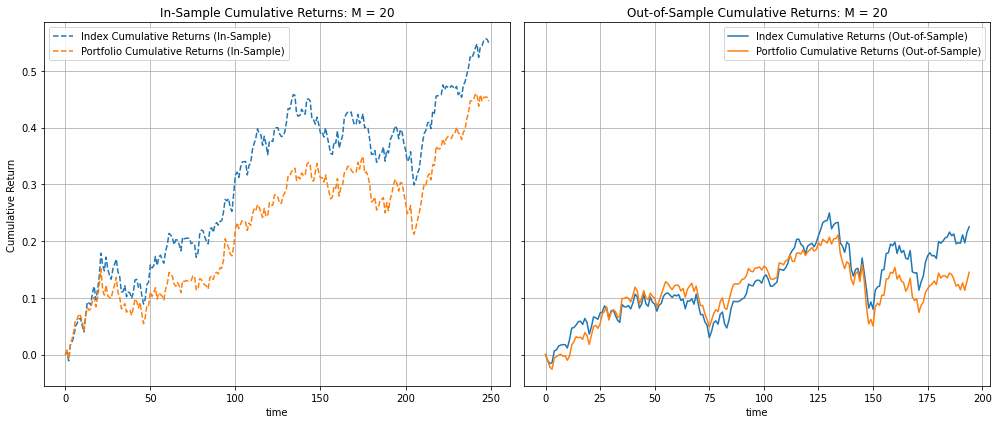

m = 30: Tracking Error 2023 = 0.7036108118856119, Tracking Error 2024 = 0.6015981160531514, Selected Stock Names: Index(['AMZN', 'AEP', 'AMAT', 'ARM', 'AZN', 'ADP', 'BKR', 'BKNG', 'CDW',
       'CHTR', 'CEG', 'CRWD', 'DDOG', 'DXCM', 'DLTR', 'EA', 'GILD', 'HON',
       'IDXX', 'LULU', 'MRNA', 'NFLX', 'NXPI', 'ORLY', 'PDD', 'PEP', 'ROST',
       'SNPS', 'TMUS', 'TTD'],
      dtype='object'), Weights: [0.18194376262323728, 0.045900609561401705, 0.08440732482879504, 0.01049225450892417, 0.0, 0.05504685273165153, 0.0, 0.06326129116336811, 0.002969664119040945, 0.02629372528681609, 0.008753389293721174, 0.022698731726530502, 0.0021760711670993993, 0.0, 0.0, 0.03862753808027067, 0.023395132357103016, 0.018244473985245042, 0.02219726111239467, 0.01792218563964115, 0.018732938071492615, 0.06284831898816653, 0.05773821836246747, 0.0, 0.018883048975830156, 0.0789516240047919, 0.0010545506435957266, 0.11553391245338791, 0.02192712031502728, 0.0]


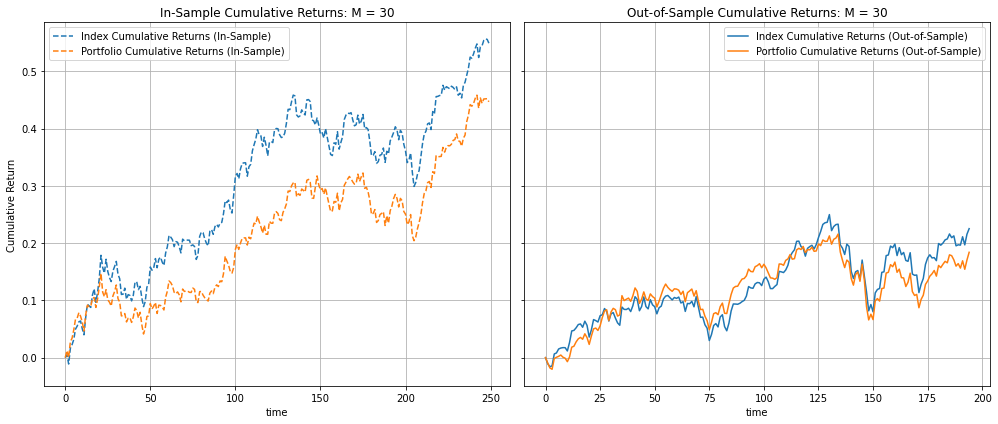

m = 40: Tracking Error 2023 = 0.6079454628329436, Tracking Error 2024 = 0.605632200464059, Selected Stock Names: Index(['AEP', 'ARM', 'AZN', 'BKNG', 'CDNS', 'CHTR', 'CTAS', 'CSCO', 'CEG',
       'COST', 'CRWD', 'FANG', 'DLTR', 'EA', 'FTNT', 'GEHC', 'GILD', 'HON',
       'ILMN', 'ISRG', 'LRCX', 'LULU', 'MELI', 'META', 'MRNA', 'MDB', 'NFLX',
       'NXPI', 'ORLY', 'ODFL', 'PAYX', 'PYPL', 'PDD', 'PEP', 'ROST', 'SBUX',
       'SMCI', 'TMUS', 'TTD', 'VRTX'],
      dtype='object'), Weights: [0.0, 0.005027414889167946, 0.012601524587013918, 0.033375569792612234, 0.10506365793888349, 0.0, 0.008214825494698015, 0.03883908161030052, 0.03136422273954845, 0.06958008259891715, 0.018863209509847417, 0.0, 0.0, 0.028440477051667606, 0.010345294120371254, 0.0, 0.0003483227285117815, 0.0, 0.007887592167303588, 0.03569208686213602, 0.0780614913157555, 0.0, 0.00942446548042674, 0.1255105180967237, 0.017614681180692954, 0.027360476882582734, 0.05062024846329309, 0.044423116486596886, 0.0, 0.013141199493545

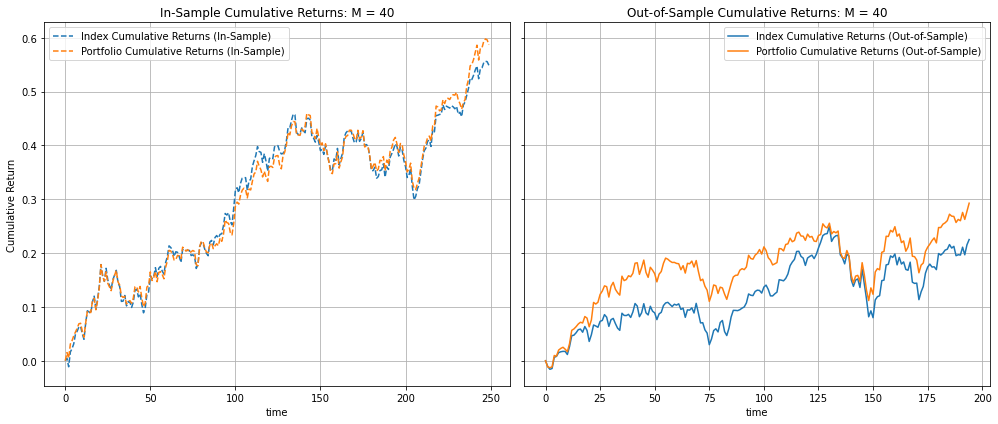

m = 50: Tracking Error 2023 = 0.4803880668911591, Tracking Error 2024 = 0.5819458404807029, Selected Stock Names: Index(['AMZN', 'AEP', 'AAPL', 'ARM', 'AZN', 'ADP', 'BKR', 'BIIB', 'CDNS',
       'CDW', 'CHTR', 'CTAS', 'CTSH', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX',
       'DLTR', 'FAST', 'FTNT', 'GEHC', 'GILD', 'ILMN', 'ISRG', 'LRCX', 'LIN',
       'LULU', 'MAR', 'MELI', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL',
       'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'TTWO',
       'TMUS', 'TSLA', 'TTD', 'VRTX', 'WBD'],
      dtype='object'), Weights: [0.13939665157451986, 0.0, 0.19027479478698092, 0.014124727512515561, 0.0, 0.021070569049806934, 0.0, 0.02816636848259689, 0.06482781488410594, 0.0, 0.02601193384585638, 0.0, 0.025817872926010062, 0.010124535474979757, 0.010818170969015833, 0.0, 0.023234172612382413, 0.0, 0.0, 0.0349071401450134, 0.0103660366908635, 0.0038449889016615234, 0.0, 0.0, 0.019174021646094365, 0.06030754516849965, 0.012545638836952894, 0.00566513

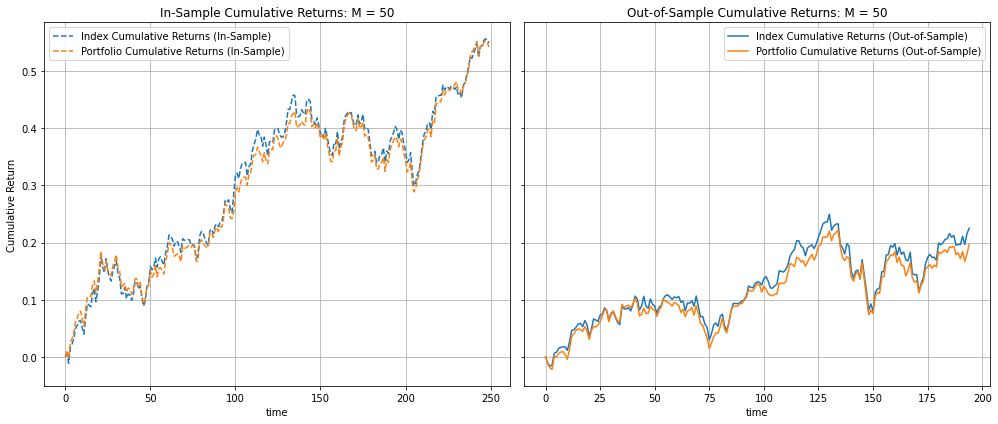

m = 60: Tracking Error 2023 = 0.44060470012150504, Tracking Error 2024 = 0.5722510472153621, Selected Stock Names: Index(['ABNB', 'AMZN', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'ADSK',
       'ADP', 'BKR', 'BIIB', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CTSH', 'CEG',
       'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'DLTR', 'DASH', 'EA',
       'FAST', 'FTNT', 'GEHC', 'GILD', 'IDXX', 'ILMN', 'INTC', 'ISRG', 'LRCX',
       'LIN', 'LULU', 'MAR', 'MELI', 'MRNA', 'NFLX', 'NXPI', 'ORLY', 'ODFL',
       'PCAR', 'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'SNPS',
       'TTWO', 'TMUS', 'TSLA', 'VRSK', 'VRTX', 'WBD'],
      dtype='object'), Weights: [0.006101689991057686, 0.12404078120564181, 0.0, 0.013014145489194603, 0.04494566028872448, 0.2100980816343145, 0.001000033642011645, 0.0, 0.013835709707286616, 0.01493498096286707, 0.0, 0.019759171609751828, 0.0, 0.017136380872450355, 0.0, 0.04126036871953798, 0.018474824735641583, 0.01671125020781549, 0.0, 0.001722765340585712, 0.0077

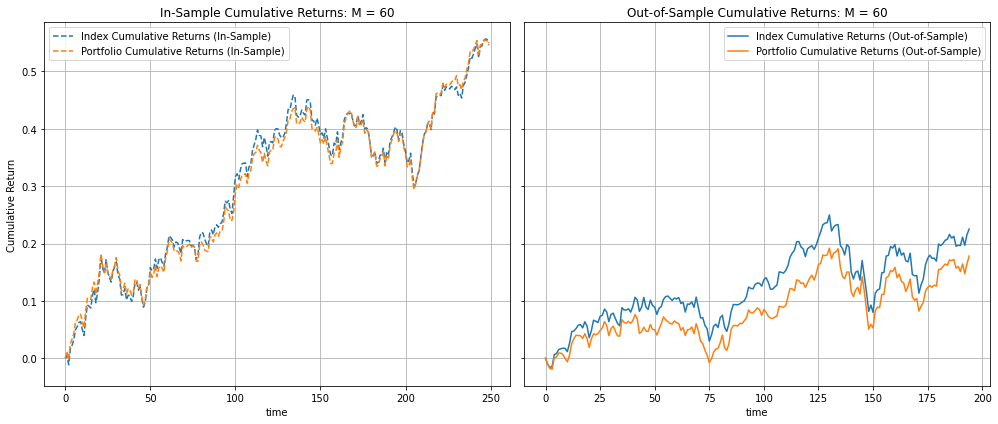

m = 70: Tracking Error 2023 = 0.2921814619385893, Tracking Error 2024 = 0.5287771607899969, Selected Stock Names: Index(['ABNB', 'GOOGL', 'AEP', 'AMGN', 'ANSS', 'AAPL', 'ARM', 'AZN', 'TEAM',
       'ADSK', 'ADP', 'BIIB', 'BKNG', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP',
       'CTSH', 'CEG', 'CSGP', 'COST', 'CRWD', 'CSX', 'DXCM', 'FANG', 'DLTR',
       'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD', 'HON', 'IDXX', 'ILMN',
       'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'LIN', 'LULU', 'MAR', 'MELI',
       'MU', 'MSFT', 'MRNA', 'MDB', 'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR',
       'PYPL', 'PDD', 'PEP', 'REGN', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO',
       'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY'],
      dtype='object'), Weights: [0.0, 0.10752559238091292, 0.0, 0.01261734431338907, 0.02949363921099635, 0.13497605332748955, 0.0, 0.010484519150173684, 0.00672424739584046, 0.0020412047237597076, 0.0, 0.0, 0.009399452849596701, 0.0, 0.0, 0.0, 0.03433364738581325, 0.02213191634288809, 0

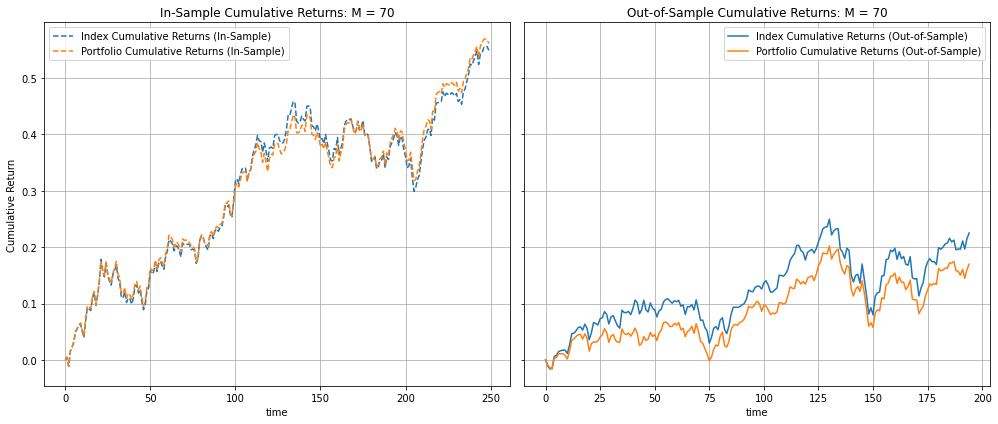

m = 80: Tracking Error 2023 = 0.15367298383343952, Tracking Error 2024 = 0.372533045562307, Selected Stock Names: Index(['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AEP', 'AMGN', 'ANSS', 'AAPL',
       'ARM', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDW',
       'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CEG', 'CSGP', 'COST', 'CSX',
       'DDOG', 'DXCM', 'DLTR', 'DASH', 'EA', 'FAST', 'FTNT', 'GEHC', 'GILD',
       'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC',
       'LIN', 'LULU', 'MAR', 'MELI', 'META', 'MU', 'MSFT', 'MRNA', 'MNST',
       'NFLX', 'NXPI', 'ORLY', 'ODFL', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD',
       'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO',
       'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'ZS'],
      dtype='object'), Weights: [0.016033263758082547, 0.026497378761306388, 0.0015420509523118358, 0.07568582220826435, 0.05585696908743584, 0.0, 0.01107998941994315, 0.016056262009384255, 0.1133343327369

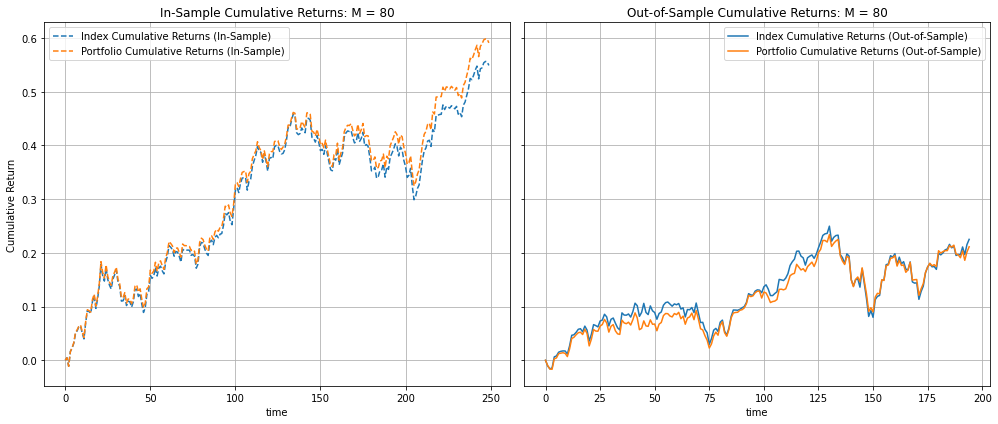

m = 90: Tracking Error 2023 = 0.10019755961844887, Tracking Error 2024 = 0.2932002746833746, Selected Stock Names: Index(['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AMGN', 'ANSS', 'AAPL', 'ARM',
       'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW',
       'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP',
       'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA',
       'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN',
       'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LIN', 'LULU', 'MAR',
       'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB',
       'MNST', 'NFLX', 'NVDA', 'ORLY', 'ODFL', 'PCAR', 'PANW', 'PAYX', 'PYPL',
       'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'TTWO',
       'TMUS', 'TSLA', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL', 'ZS'],
      dtype='object'), Weights: [0.010594484180991907, 0.016630150970962602, 0.0, 0.07281156145465907, 0.05895321717717

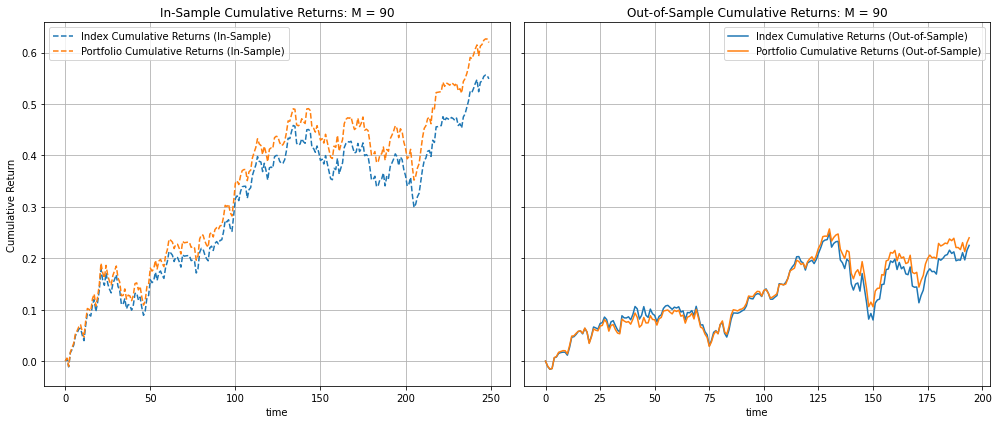

m = 100: Tracking Error 2023 = 0.08811300837119276, Tracking Error 2024 = 0.27703116089958635, Selected Stock Names: Index(['ADBE', 'AMD', 'ABNB', 'GOOGL', 'AMZN', 'AEP', 'AMGN', 'ADI', 'ANSS',
       'AAPL', 'AMAT', 'ARM', 'ASML', 'AZN', 'TEAM', 'ADSK', 'ADP', 'BKR',
       'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP',
       'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG',
       'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC',
       'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP',
       'KLAC', 'KHC', 'LRCX', 'LIN', 'LULU', 'MAR', 'MRVL', 'MELI', 'META',
       'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA',
       'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD',
       'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SMCI', 'SNPS', 'TTWO',
       'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL',
       'ZS'],
      dtype='object'), Weight

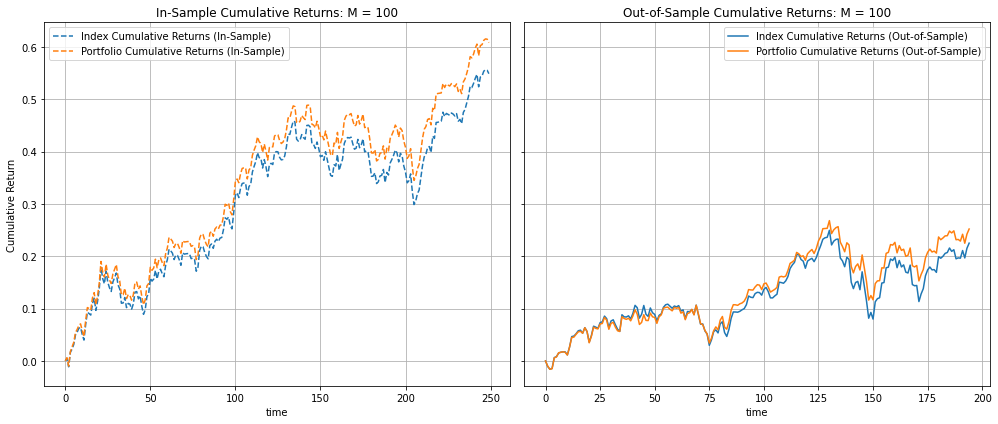

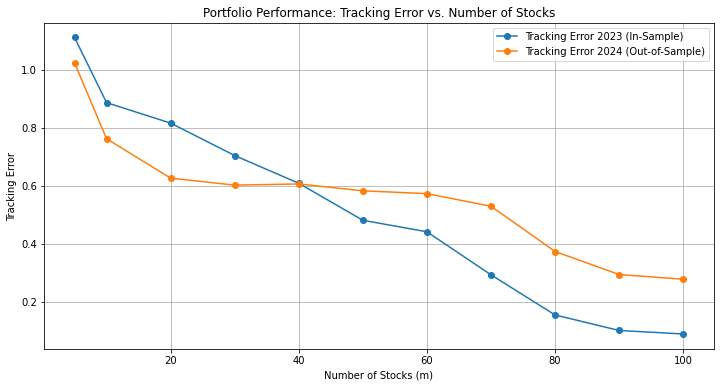

In [4]:
def run_analysis(stock_returns_2023, index_returns_2023, stock_returns_2024, index_returns_2024, rho):
    results = []
    #for m in range(10, min(101, stock_returns_2023.shape[1]) + 1, 10):
    for m in [5] + list(range(10, min(101, stock_returns_2023.shape[1]) + 1, 10)):
        selected = select_stocks(m, rho)
        weights = optimize_weights(selected, stock_returns_2023, index_returns_2023)
        #tracking_error_2023 = calculate_tracking_error(weights, selected, stock_returns_2023, index_returns_2023)
        
        cumulative_portfolio_returns_2023, cumulative_index_returns_2023, tracking_error_2023 = \
    evaluate_performance(weights, selected, stock_returns_2023, index_returns_2023)
        
        #tracking_error_2024 = calculate_tracking_error(weights, selected, stock_returns_2024, index_returns_2024)
        cumulative_portfolio_returns_2024, cumulative_index_returns_2024, tracking_error_2024 = \
    evaluate_performance(weights, selected, stock_returns_2024, index_returns_2024)
        
        results.append({
            'm': m,
            'tracking_error_2023': tracking_error_2023,
            'tracking_error_2024': tracking_error_2024
        })
        print(f"m = {m}: Tracking Error 2023 = {tracking_error_2023}, Tracking Error 2024 = {tracking_error_2024}, Selected Stock Names: {stock_returns_2024.columns[selected]}, Weights: {weights}")
        # -------------
        #print(cumulative_portfolio_returns_2024, cumulative_index_returns_2024)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
        # Plot the in-sample cumulative returns on the left subplot
        ax1.plot(cumulative_index_returns_2023, label='Index Cumulative Returns (In-Sample)', linestyle='--')
        ax1.plot(cumulative_portfolio_returns_2023, label='Portfolio Cumulative Returns (In-Sample)', linestyle='--')
        ax1.set_title(f'In-Sample Cumulative Returns: M = {m}')
        ax1.set_xlabel('time')
        ax1.set_ylabel('Cumulative Return')
        ax1.legend()
        ax1.grid(True)
        
         # Plot the out-of-sample cumulative returns on the right subplot
        ax2.plot(cumulative_index_returns_2024, label='Index Cumulative Returns (Out-of-Sample)', linestyle='-')
        ax2.plot(cumulative_portfolio_returns_2024, label='Portfolio Cumulative Returns (Out-of-Sample)', linestyle='-')
        ax2.set_title(f'Out-of-Sample Cumulative Returns: M = {m}')
        ax2.set_xlabel('time')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        #-------------
    return pd.DataFrame(results)

try:
    results_df = run_analysis(stock_returns_2023, index_returns_2023, stock_returns_2024, index_returns_2024, rho)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['m'], results_df['tracking_error_2023'], label='Tracking Error 2023 (In-Sample)', marker='o')
    plt.plot(results_df['m'], results_df['tracking_error_2024'], label='Tracking Error 2024 (Out-of-Sample)', marker='o')
    plt.xlabel('Number of Stocks (m)')
    plt.ylabel('Tracking Error')
    plt.title('Portfolio Performance: Tracking Error vs. Number of Stocks')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred during the analysis: {e}")

In [5]:
results_df_normal = results_df
results_df_normal

,m,tracking_error_2023,tracking_error_2024
0,5,1.110995,1.023837
1,10,0.886172,0.761629
2,20,0.815582,0.625690
3,30,0.703611,0.601598
4,40,0.607945,0.605632
5,50,0.480388,0.581946
6,60,0.440605,0.572251
7,70,0.292181,0.528777
8,80,0.153673,0.372533
9,90,0.100198,0.293200


## MIP with Big M

Running MIP for m = 10...
Set parameter TimeLimit to value 3600
m = 10: Tracking Error 2023 = 0.3599376655227376, Tracking Error 2024 = 0.5886510381762439, Time Taken = 3600.61 seconds


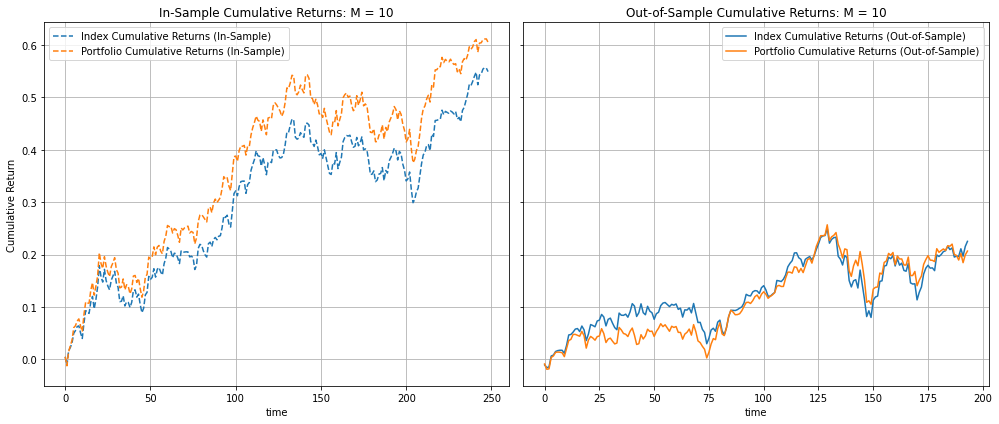

Running MIP for m = 20...
Set parameter TimeLimit to value 3600
m = 20: Tracking Error 2023 = 0.19612725440108614, Tracking Error 2024 = 0.347699046783305, Time Taken = 3600.40 seconds


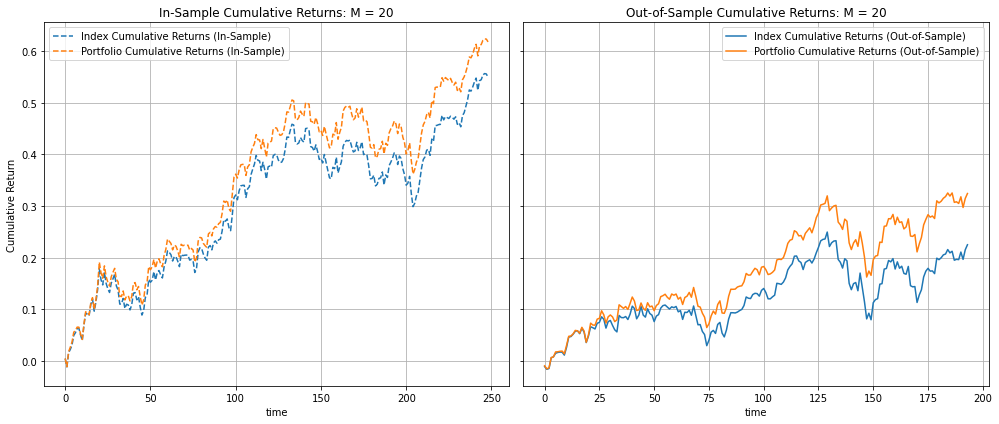

Running MIP for m = 30...
Set parameter TimeLimit to value 3600
m = 30: Tracking Error 2023 = 0.1325927596321318, Tracking Error 2024 = 0.2791351168659314, Time Taken = 3600.39 seconds


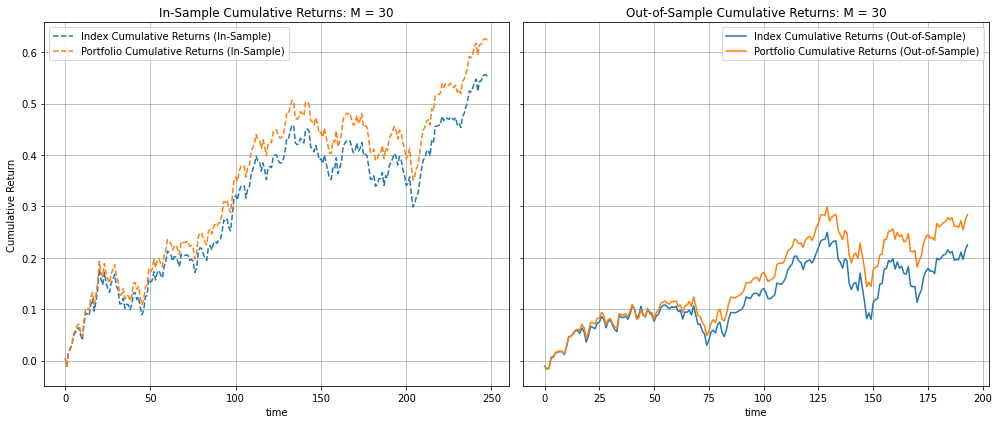

Running MIP for m = 40...
Set parameter TimeLimit to value 3600
m = 40: Tracking Error 2023 = 0.10737580224477292, Tracking Error 2024 = 0.28070242281898883, Time Taken = 3600.42 seconds


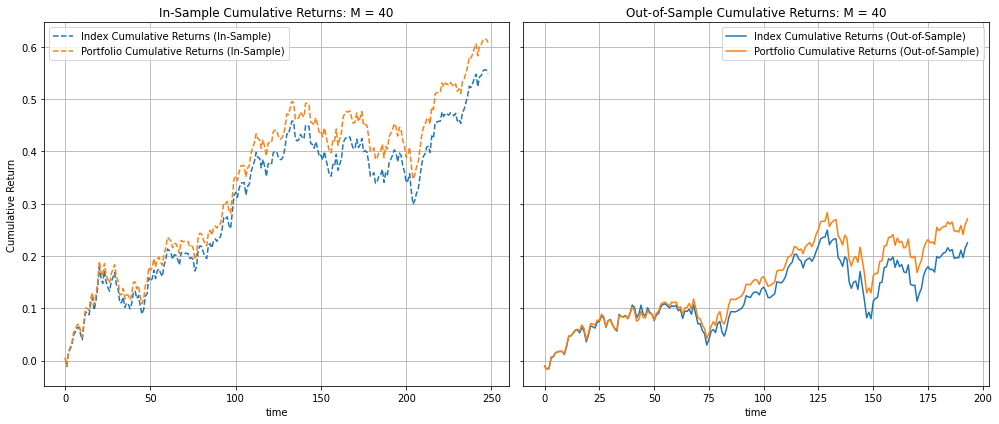

Running MIP for m = 50...
Set parameter TimeLimit to value 3600
m = 50: Tracking Error 2023 = 0.09648166476392417, Tracking Error 2024 = 0.3093702427926196, Time Taken = 3600.53 seconds


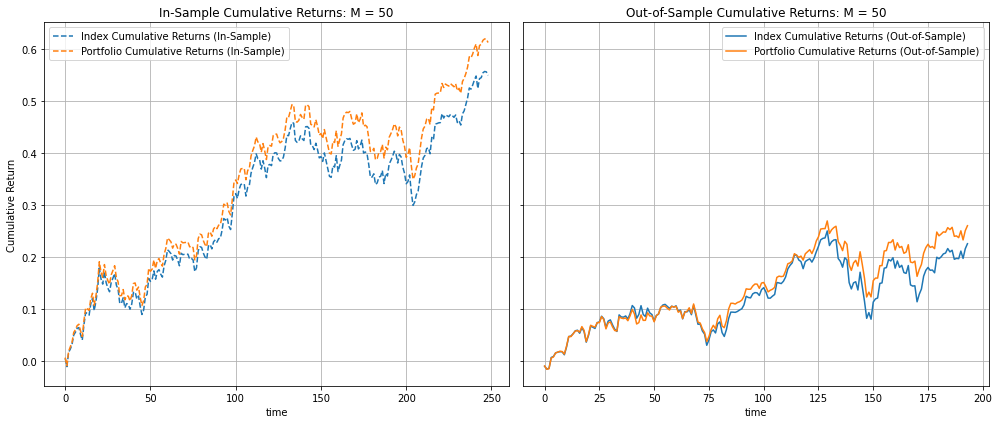

Running MIP for m = 60...
Set parameter TimeLimit to value 3600
m = 60: Tracking Error 2023 = 0.09099037708650641, Tracking Error 2024 = 0.3044007955499652, Time Taken = 3600.81 seconds


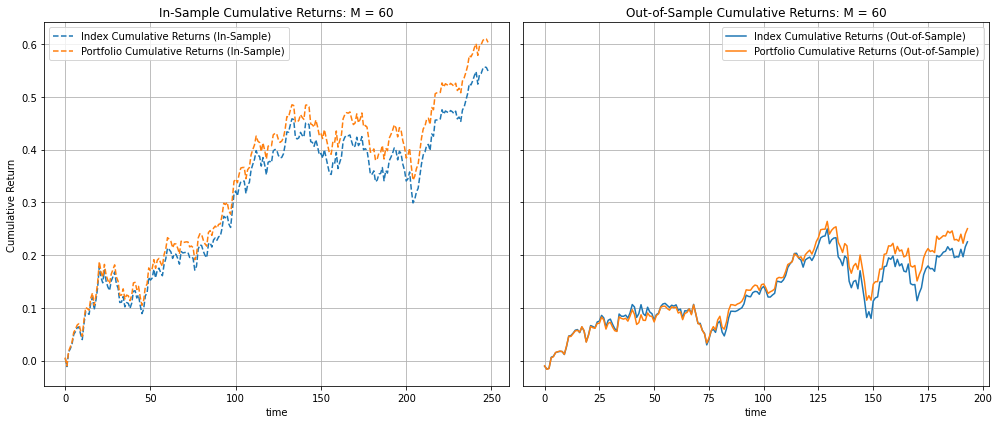

Running MIP for m = 70...
Set parameter TimeLimit to value 3600
m = 70: Tracking Error 2023 = 0.08928376454443035, Tracking Error 2024 = 0.28918671161027015, Time Taken = 256.75 seconds


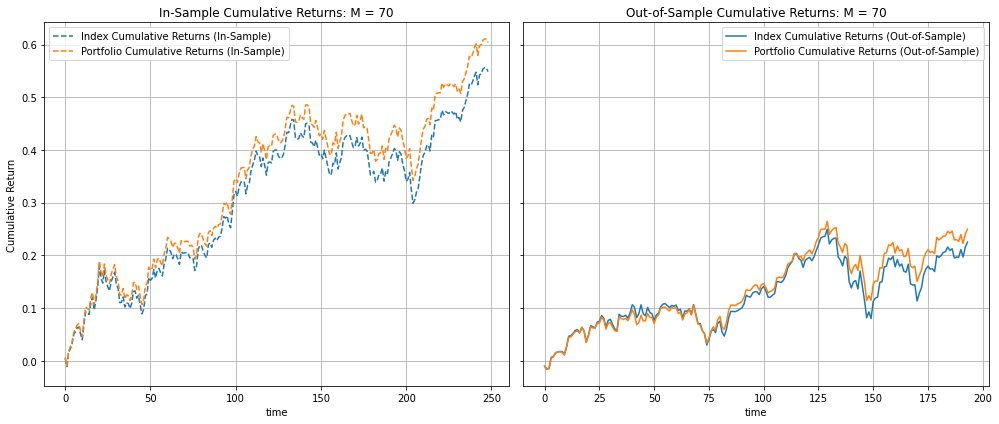

Running MIP for m = 80...
Set parameter TimeLimit to value 3600
m = 80: Tracking Error 2023 = 0.08981632104182219, Tracking Error 2024 = 0.2803141179947175, Time Taken = 2.32 seconds


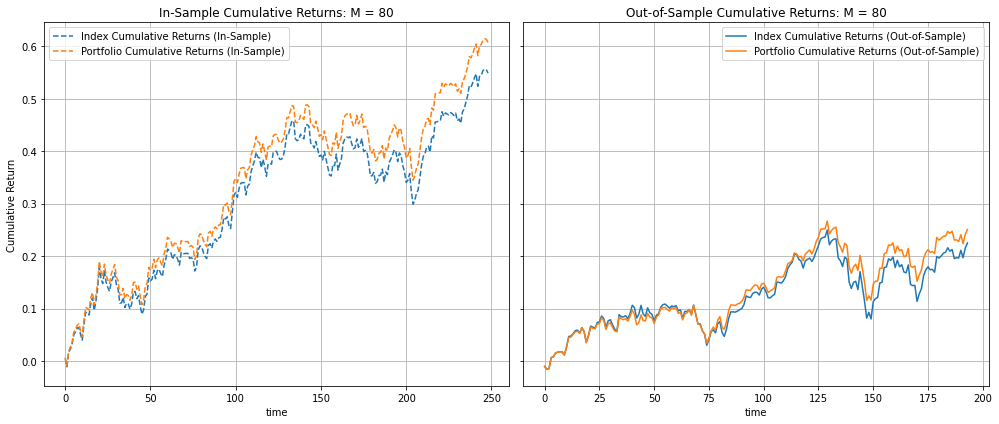

Running MIP for m = 90...
Set parameter TimeLimit to value 3600
m = 90: Tracking Error 2023 = 0.08982801574473018, Tracking Error 2024 = 0.2804407361935902, Time Taken = 1.69 seconds


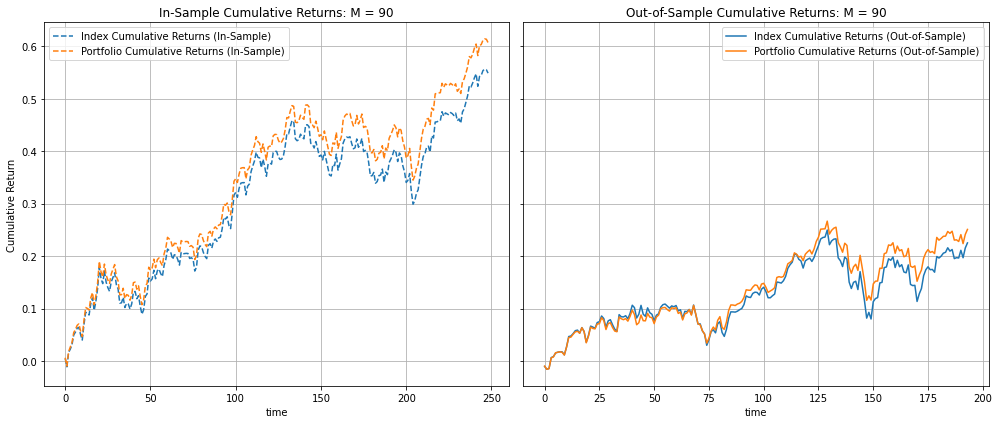

Running MIP for m = 100...
Set parameter TimeLimit to value 3600
m = 100: Tracking Error 2023 = 0.08982801574472987, Tracking Error 2024 = 0.2804407361935887, Time Taken = 0.29 seconds


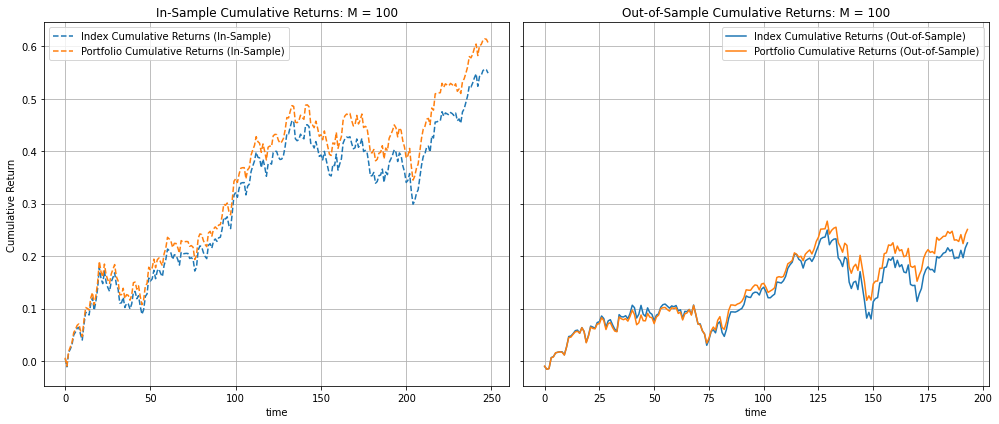

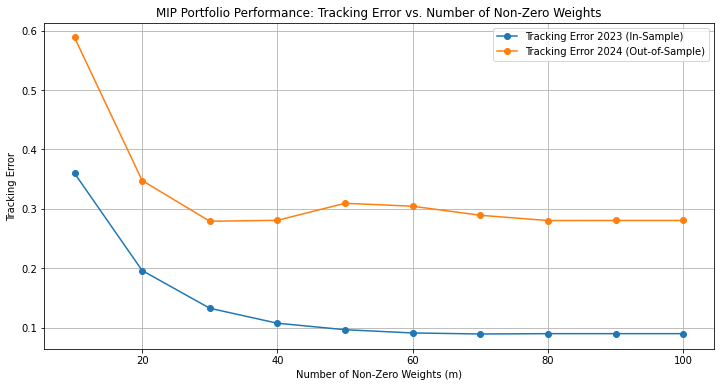

In [27]:
import pandas as pd
import numpy as np
import os
import time
from gurobipy import Model, GRB

TIME_LIMIT = 3600  #(3600 seconds)
BIG_M = 1

# The smallest big M value should be the max possible weight, which is 1 since all weights sum to 1.

data_2023 = data_2023.interpolate(method='linear', axis=0).fillna(method='ffill').fillna(method='bfill')
data_2024 = data_2024.interpolate(method='linear', axis=0).fillna(method='ffill').fillna(method='bfill')


# Compute daily returns
returns_2023 = data_2023.iloc[:, 1:].pct_change().fillna(0)
returns_2024 = data_2024.iloc[:, 1:].pct_change().fillna(0)

index_returns_2023 = returns_2023.iloc[:, 0]
stock_returns_2023 = returns_2023.iloc[:, 1:]

index_returns_2024 = returns_2024.iloc[:, 0]
stock_returns_2024 = returns_2024.iloc[:, 1:]

n = stock_returns_2023.shape[1]  # Number of stocks

# === Check for existing results to avoid re-solving ===
RESULTS_FILE = "mip_results.csv"

def evaluate_performance(weights, selected_stocks, stock_returns, index_returns):
    # Ensure selected_stocks contains column names
    selected_columns = [col for col in stock_returns.columns if col in selected_stocks]
    
    # Extract the relevant stock returns for the selected columns
    selected_returns = stock_returns[selected_columns].dropna()

    # Check that the weights array matches the number of selected stocks
    if len(weights) != len(selected_columns):
        raise ValueError("Mismatch between number of weights and selected stocks.")

    # Align index returns with the selected stock returns
    aligned_index_returns = index_returns.loc[selected_returns.index]

    # Compute portfolio returns using matrix multiplication
    portfolio_returns = selected_returns.values @ np.array(weights)

    # Calculate cumulative returns for portfolio and index
    cumulative_portfolio_returns = np.cumprod(1 + portfolio_returns) - 1
    cumulative_index_returns = np.cumprod(1 + aligned_index_returns.values) - 1

    # Calculate tracking error as the mean absolute difference
    tracking_error = np.sum(np.abs(portfolio_returns - aligned_index_returns.values))

    return cumulative_portfolio_returns, cumulative_index_returns, tracking_error


def mip_weight_selection(m, stock_returns, index_returns, time_limit):
    T, n = stock_returns.shape

    # Convert data to NumPy arrays for compatibility with Gurobi
    stock_returns_array = stock_returns.to_numpy()
    index_returns_array = index_returns.to_numpy()

    # Create Gurobi model
    model = Model()
    model.Params.TimeLimit = time_limit  # Set time limit for Gurobi
    model.Params.OutputFlag = 0  # Suppress solver output

    # Variables
    w = model.addVars(n, lb=0, ub=BIG_M, name="w")  # Weight variables
    y = model.addVars(n, vtype=GRB.BINARY, name="y")  # Binary variables
    deviations = model.addVars(T, lb=0, name="dev")  # Deviation variables

    # Objective: Minimize sum of absolute deviations
    model.setObjective(quicksum(deviations[t] for t in range(T)), GRB.MINIMIZE)

    # Constraints to model absolute deviations
    for t in range(T):
        # Calculate the portfolio return for time t using NumPy arrays
        portfolio_return_t = quicksum(w[i] * stock_returns_array[t, i] for i in range(n))

        # Add absolute deviation constraints
        model.addConstr(deviations[t] >= index_returns_array[t] - portfolio_return_t)
        model.addConstr(deviations[t] >= portfolio_return_t - index_returns_array[t])

    # Sum of weights must equal 1
    model.addConstr(sum(w[i] for i in range(n)) == 1)

    # Big-M constraint: If y_i = 0, then w_i must be 0
    for i in range(n):
        model.addConstr(w[i] <= y[i] * BIG_M)

    # Sum of binary variables must equal m (number of non-zero weights)
    model.addConstr(quicksum(y[i] for i in range(n)) == m)

    # Optimize the model
    model.optimize()

    # Extract results
    #weights = np.array([w[i].x for i in range(n)])
    
    #----
    portfolio_weights = {stock_returns.columns[i]: w[i].x for i in range(n) if w[i].x > 0.001}
    selected_stocks = [stock_returns.columns[i] for i in range(n) if y[i].x > 0.5]
    return portfolio_weights, selected_stocks, model.ObjVal
    # ----

def run_mip_analysis(stock_returns_2023, index_returns_2023, stock_returns_2024, index_returns_2024, time_limit):
    # Check if results already exist
    if os.path.exists(RESULTS_FILE):
        print(f"Loading existing results from {RESULTS_FILE}")
        return pd.read_csv(RESULTS_FILE)

    results = []

    for m in [5] + list(range(10, min(101, stock_returns_2023.shape[1]) + 1, 10)):
        print(f"Running MIP for m = {m}...")
        
        start_time = time.time()
        
        # Solve the MIP weight selection problem
        weights_dict, selected_stocks, ObjVal = mip_weight_selection(m, stock_returns_2023, index_returns_2023, time_limit)
        
        #-------
        weights = np.array([weights_dict.get(stock, 0) for stock in selected_stocks])
            
        # Calculate tracking errors for 2023 and 2024
        cumulative_portfolio_returns_2023, cumulative_index_returns_2023, tracking_error_2023 = \
    evaluate_performance(weights, selected_stocks, stock_returns_2023, index_returns_2023)
        
        #tracking_error_2024 = calculate_tracking_error(weights, selected, stock_returns_2024, index_returns_2024)
        cumulative_portfolio_returns_2024, cumulative_index_returns_2024, tracking_error_2024 = \
    evaluate_performance(weights, selected_stocks, stock_returns_2024, index_returns_2024)
        
        
        end_time = time.time()
        iteration_time = end_time - start_time
        
        results.append({
            'm': m,
            'tracking_error_2023': tracking_error_2023,
            'tracking_error_2024': tracking_error_2024,
            'time_taken': iteration_time
        })

        print(f"m = {m}: Tracking Error 2023 = {tracking_error_2023}, Tracking Error 2024 = {tracking_error_2024},selected_stocks = {selected_stocks}, Time Taken = {iteration_time:.2f} seconds")
        
        #print(cumulative_portfolio_returns_2024, cumulative_index_returns_2024)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
        # --------------------
        # Plot the in-sample cumulative returns on the left subplot
        ax1.plot(cumulative_index_returns_2023, label='Index Cumulative Returns (In-Sample)', linestyle='--')
        ax1.plot(cumulative_portfolio_returns_2023, label='Portfolio Cumulative Returns (In-Sample)', linestyle='--')
        ax1.set_title(f'In-Sample Cumulative Returns: M = {m}')
        ax1.set_xlabel('time')
        ax1.set_ylabel('Cumulative Return')
        ax1.legend()
        ax1.grid(True)
        
         # Plot the out-of-sample cumulative returns on the right subplot
        ax2.plot(cumulative_index_returns_2024, label='Index Cumulative Returns (Out-of-Sample)', linestyle='-')
        ax2.plot(cumulative_portfolio_returns_2024, label='Portfolio Cumulative Returns (Out-of-Sample)', linestyle='-')
        ax2.set_title(f'Out-of-Sample Cumulative Returns: M = {m}')
        ax2.set_xlabel('time')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        # ----------------
    # Save results to CSV to avoid re-solving
    results_df = pd.DataFrame(results)
    results_df.to_csv(RESULTS_FILE, index=False)
    return results_df

# Run the MIP analysis and display the results

results_df = run_mip_analysis(stock_returns_2023, index_returns_2023, stock_returns_2024, index_returns_2024, TIME_LIMIT)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(results_df['m'], results_df['tracking_error_2023'], label='Tracking Error 2023 (In-Sample)', marker='o')
plt.plot(results_df['m'], results_df['tracking_error_2024'], label='Tracking Error 2024 (Out-of-Sample)', marker='o')
plt.xlabel('Number of Non-Zero Weights (m)')
plt.ylabel('Tracking Error')
plt.title('MIP Portfolio Performance: Tracking Error vs. Number of Non-Zero Weights')
plt.legend()
plt.grid(True)
plt.show()



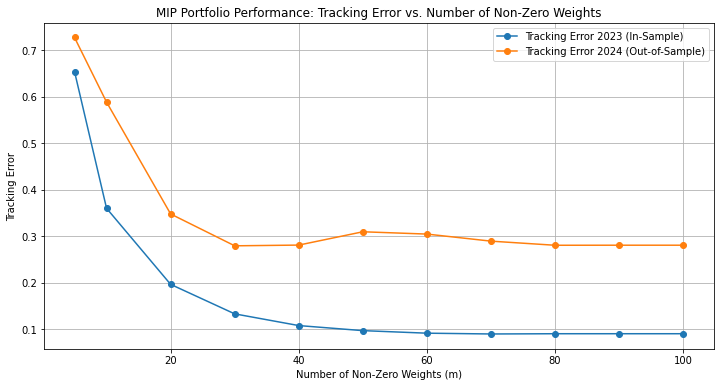

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results_df['m'], results_df['tracking_error_2023'], label='Tracking Error 2023 (In-Sample)', marker='o')
plt.plot(results_df['m'], results_df['tracking_error_2024'], label='Tracking Error 2024 (Out-of-Sample)', marker='o')
plt.xlabel('Number of Non-Zero Weights (m)')
plt.ylabel('Tracking Error')
plt.title('MIP Portfolio Performance: Tracking Error vs. Number of Non-Zero Weights')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
results_df_bigM = results_df
results_df_bigM

,m,tracking_error_2023,tracking_error_2024,time_taken
0,5,0.654442,0.727812,1506.620000
1,10,0.359938,0.588651,3600.605532
2,20,0.196127,0.347699,3600.401436
3,30,0.132593,0.279135,3600.388991
4,40,0.107376,0.280702,3600.422608
5,50,0.096482,0.309370,3600.534892
6,60,0.090990,0.304401,3600.805344
7,70,0.089284,0.289187,256.745197
8,80,0.089816,0.280314,2.315901
9,90,0.089828,0.280441,1.689465


In [10]:
results_df_normal

,m,tracking_error_2023,tracking_error_2024
0,5,1.110995,1.023837
1,10,0.886172,0.761629
2,20,0.815582,0.625690
3,30,0.703611,0.601598
4,40,0.607945,0.605632
5,50,0.480388,0.581946
6,60,0.440605,0.572251
7,70,0.292181,0.528777
8,80,0.153673,0.372533
9,90,0.100198,0.293200


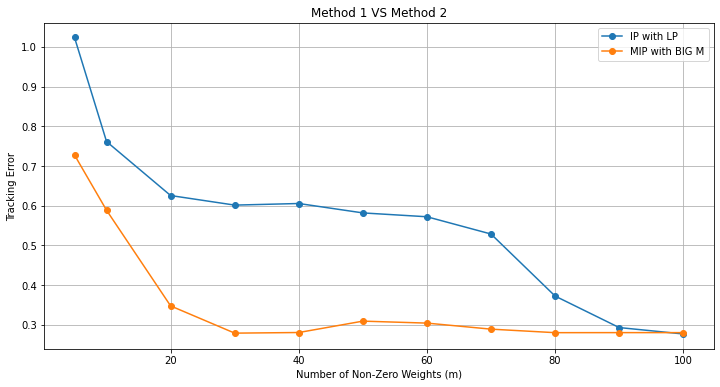

In [11]:

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(results_df_normal['m'], results_df_normal['tracking_error_2024'], label='IP with LP', marker='o')
plt.plot(results_df_bigM['m'], results_df_bigM['tracking_error_2024'], label='MIP with BIG M', marker='o')
plt.xlabel('Number of Non-Zero Weights (m)')
plt.ylabel('Tracking Error')
plt.title('Method 1 VS Method 2')
plt.legend()
plt.grid(True)
plt.show()
